# Model Training Notebook

* Author: Finian O'Neill
* Purpose: Conduct the feature engineering on the training dataset. Then, create a ML pipeline to train a regression model.

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

In [2]:
def cluster_similar_categories(df, column_name, n_clusters=None, similarity_threshold=0.7):
    """
    Groups semantically similar categories using text similarity and clustering
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe
    column_name : str
        Name of the categorical column to process
    n_clusters : int, optional
        Number of clusters to create. If None, determined automatically
    similarity_threshold : float, optional
        Threshold for considering categories similar in automatic mode
        
    Returns:
    --------
    df_copy : pandas DataFrame
        DataFrame with the new clustered column
    mapping : dict
        Mapping from original categories to cluster labels
    """
    df_copy = df.copy()
    
    # Get unique categories
    categories = df[column_name].dropna().unique().tolist()
    
    # If very few categories, no need to cluster
    if len(categories) <= 5:
        print(f"Only {len(categories)} categories found. No clustering needed.")
        return df_copy, {cat: cat for cat in categories}
    
    # Convert categories to strings
    categories = [str(cat) for cat in categories]
    
    # Create TF-IDF vectors for the categories
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
    tfidf_matrix = vectorizer.fit_transform(categories)
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Determine number of clusters if not provided
    if n_clusters is None:
        # Use elbow method or silhouette score
        distortions = []
        K_range = range(1, min(15, len(categories)))
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(tfidf_matrix)
            distortions.append(kmeans.inertia_)
        
        # Find "elbow" point - simple heuristic
        deltas = np.diff(distortions)
        n_clusters = np.argmax(deltas) + 1
        n_clusters = max(n_clusters, 2)  # At least 2 clusters
        
        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K_range, distortions, 'bx-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method For Optimal Clusters')
        plt.axvline(x=n_clusters, color='r', linestyle='--')
        plt.show()
        
        print(f"Auto-selected {n_clusters} clusters based on elbow method")
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    # Create mapping from original categories to cluster labels
    mapping = {}
    cluster_groups = defaultdict(list)
    
    for cat, label in zip(categories, cluster_labels):
        cluster_groups[label].append(cat)
    
    # Create meaningful names for clusters
    for label, members in cluster_groups.items():
        if len(members) == 1:
            # If only one member, keep original name
            cluster_name = members[0]
        else:
            # Find most frequent or representative member
            counts = df[df[column_name].isin(members)][column_name].value_counts()
            most_common = counts.index[0] if not counts.empty else members[0]
            cluster_name = f"{most_common}_cluster_{label}"
        
        # Map all members to this cluster name
        for member in members:
            mapping[member] = cluster_name
    
    # Apply mapping to create new column
    new_col_name = f"{column_name}_clustered"
    df_copy[new_col_name] = df_copy[column_name].astype(str).map(mapping)
    df_copy[new_col_name] = df_copy[new_col_name].fillna('other')
    
    # Print cluster statistics
    original_count = len(categories)
    new_count = len(set(mapping.values()))
    print(f"Reduced cardinality from {original_count} to {new_count} categories")
    
    # Print samples from each cluster to verify semantic similarity
    print("\nSample clusters:")
    for label, members in list(cluster_groups.items())[:5]:  # Show first 5 clusters
        print(f"Cluster {label}: {', '.join(members[:5])}" + 
              (f" ... and {len(members)-5} more" if len(members) > 5 else ""))
    
    return df_copy, mapping

In [3]:
def visualize_distribution(df, column_name, figsize=(12, 10)):
    """
    Visualize the distribution of a column in a pandas DataFrame using multiple plot types.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data
    column_name (str): The name of the column to visualize
    figsize (tuple): Figure size as (width, height)
    """
    # Check if column exists
    if column_name not in df.columns:
        print(f"Column '{column_name}' not found in DataFrame")
        return
    
    # Get the data
    data = df[column_name].dropna()
    
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle(f'Distribution of {column_name}', fontsize=16)
    
    # 1. Histogram with KDE
    axes[0, 0].set_title('Histogram with KDE')
    sns.histplot(data, kde=True, ax=axes[0, 0])
    
    # 2. Box plot
    axes[0, 1].set_title('Box Plot')
    sns.boxplot(x=data, ax=axes[0, 1])
    
    # 3. Violin plot
    axes[1, 0].set_title('Violin Plot')
    sns.violinplot(y=data, ax=axes[1, 0])
    
    # 4. Empirical Cumulative Distribution Function (ECDF)
    axes[1, 1].set_title('ECDF')
    sorted_data = np.sort(data)
    y = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    axes[1, 1].plot(sorted_data, y, marker='.', linestyle='none')
    axes[1, 1].set_xlabel(column_name)
    axes[1, 1].set_ylabel('Cumulative Probability')
    
    # Add basic statistics as text
    stats_text = (
        f"Count: {len(data)}\n"
        f"Mean: {data.mean():.2f}\n"
        f"Median: {data.median():.2f}\n"
        f"Std Dev: {data.std():.2f}\n"
        f"Min: {data.min():.2f}\n"
        f"Max: {data.max():.2f}\n"
        f"Skewness: {data.skew():.2f}\n"
        f"Kurtosis: {data.kurt():.2f}"
    )
    
    fig.text(0.02, 0.02, stats_text, fontsize=10, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()
    
    # Check for potential outliers using IQR method
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    
    print(f"\nBasic Statistics for {column_name}:")
    print(f"Count: {len(data)}")
    print(f"Mean: {data.mean():.2f}")
    print(f"Median: {data.median():.2f}")
    print(f"Std Dev: {data.std():.2f}")
    print(f"Min: {data.min():.2f}")
    print(f"Max: {data.max():.2f}")
    print(f"Skewness: {data.skew():.2f}")
    print(f"Kurtosis: {data.kurt():.2f}")
    print(f"Potential outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)")

# Example usage
# visualize_distribution(train_encoded_df, 'your_column_name')

In [4]:
def save_with_json(obj, filename):
    """Save object to file using JSON.
    Note: Only works with JSON-serializable objects (dicts, lists, strings, numbers, booleans, None)
    """
    with open(filename, 'w') as f:  # 'w' for write text mode
        json.dump(obj, f, indent=4)
    print(f"Object saved to {filename} using JSON")

In [5]:
def drop_if_multiple_nulls(df, columns_to_check):
    """
    Drop rows from a DataFrame where all specified columns are null/NaN.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame to process
    columns_to_check (list): List of column names to check for null values
    
    Returns:
    pandas.DataFrame: DataFrame with rows removed where specified columns are all null
    """
    # Create a copy to avoid modifying the original
    df_clean = df.copy()
    
    # Check which columns actually exist in the dataframe
    valid_columns = [col for col in columns_to_check if col in df.columns]
    
    if not valid_columns:
        print("None of the specified columns exist in the DataFrame")
        return df
    
    # Create a mask where rows have all specified columns as null
    null_mask = df_clean[valid_columns].isnull().all(axis=1)
    
    # Count rows that will be dropped
    rows_to_drop = null_mask.sum()
    
    # Drop rows where all specified columns are null
    df_clean = df_clean[~null_mask]
    
    print(f"Dropped {rows_to_drop} rows where all of these columns were null: {valid_columns}")
    print(f"Original shape: {df.shape}, New shape: {df_clean.shape}")
    
    return df_clean

# Example usage:
# columns_of_interest = ['column1', 'column2', 'column3']
# train_encoded_df_clean = drop_if_multiple_nulls(train_encoded_df, columns_of_interest)

### Data Import

In [6]:
# load train dataset and expect
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


### Feature Engineering

#### 1) Podcast_Name

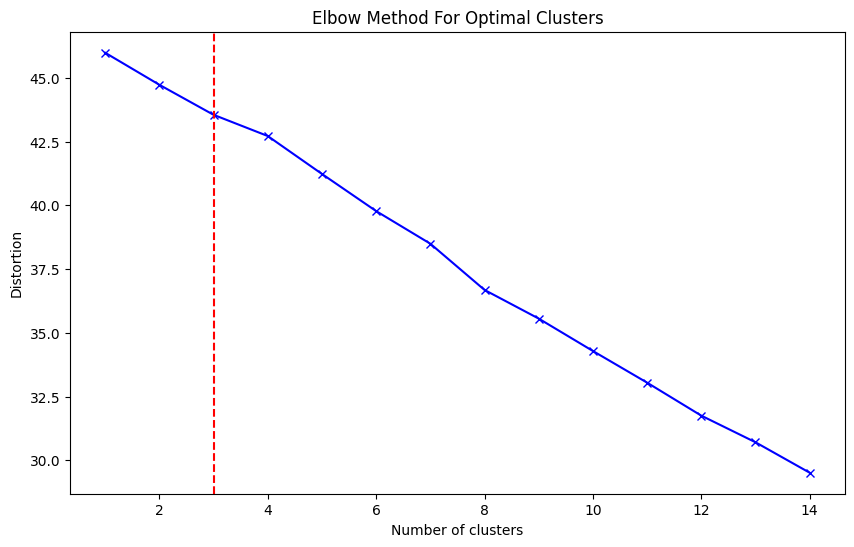

Auto-selected 3 clusters based on elbow method
Reduced cardinality from 48 to 3 categories

Sample clusters:
Cluster 0: Mystery Matters, Joke Junction, Music Matters, Melody Mix, Game Day ... and 14 more
Cluster 1: Study Sessions, Digital Digest, Mind & Body, Fitness First, Criminal Minds ... and 14 more
Cluster 2: News Roundup, Global News, Tech Trends, Health Hour, Sound Waves ... and 5 more


,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,Tech Talks_cluster_0
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,Tech Talks_cluster_0
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,Sports Weekly_cluster_1
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,Sports Weekly_cluster_1
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,Sports Weekly_cluster_1


In [7]:
# go through example of clustering the Podcast_Name
train_clustered_df, podcast_name_cluster_map = cluster_similar_categories(df=train_df, column_name='Podcast_Name')
train_clustered_df.head()

In [8]:
# save the serialized version of podcast_name_cluster_map to file to be used in inference
save_with_json(obj=podcast_name_cluster_map, filename='artifacts/podcast_name_cluster_map.json')

Object saved to artifacts/podcast_name_cluster_map.json using JSON


In [9]:
# post the clustering the clusters can then be one-hot encoded since there are only 3
train_encoded_df = pd.get_dummies(train_clustered_df, columns=['Podcast_Name_clustered'])
train_encoded_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False


In [10]:
# drop the no longer needed 'Podcast_Name' column
train_encoded_df = train_encoded_df.drop(columns=['Podcast_Name'])
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False


#### 2) Episode_Title

In [11]:
# from this list, it seems like episodes range from 1 to 100. I will simplify assumptions and just bin
# as the following for each podcast
# early --> 1 - 33
# mid --> 34 - 66
# late --> 67 - 100
early_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if n + 1 <= 33]
mid_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if (n + 1 > 33) and (n + 1 <= 66)]
late_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if (n + 1 > 66) and (n + 1 <= 100)]

# create episode dict
episode_map = {}
# add early entries
for i in range(len(early_list)):
    episode_map[early_list[i]] = 'early'
# add mid entries
for j in range(len(mid_list)):
    episode_map[mid_list[j]] = 'mid'
# add late entries
for k in range(len(late_list)):
    episode_map[late_list[k]] = 'late'
    
print(episode_map)

{'Episode 1': 'early', 'Episode 2': 'early', 'Episode 3': 'early', 'Episode 4': 'early', 'Episode 5': 'early', 'Episode 6': 'early', 'Episode 7': 'early', 'Episode 8': 'early', 'Episode 9': 'early', 'Episode 10': 'early', 'Episode 11': 'early', 'Episode 12': 'early', 'Episode 13': 'early', 'Episode 14': 'early', 'Episode 15': 'early', 'Episode 16': 'early', 'Episode 17': 'early', 'Episode 18': 'early', 'Episode 19': 'early', 'Episode 20': 'early', 'Episode 21': 'early', 'Episode 22': 'early', 'Episode 23': 'early', 'Episode 24': 'early', 'Episode 25': 'early', 'Episode 26': 'early', 'Episode 27': 'early', 'Episode 28': 'early', 'Episode 29': 'early', 'Episode 30': 'early', 'Episode 31': 'early', 'Episode 32': 'early', 'Episode 33': 'early', 'Episode 34': 'mid', 'Episode 35': 'mid', 'Episode 36': 'mid', 'Episode 37': 'mid', 'Episode 38': 'mid', 'Episode 39': 'mid', 'Episode 40': 'mid', 'Episode 41': 'mid', 'Episode 42': 'mid', 'Episode 43': 'mid', 'Episode 44': 'mid', 'Episode 45': 'mid

In [12]:
# bin the actual 'Episode_Title' column
train_encoded_df['Episode_Title_binned'] = train_encoded_df['Episode_Title'].map(episode_map).fillna('unknown')
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,late
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,early
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,early
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,mid
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,late


In [13]:
# now one hot encode the binned values
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Episode_Title_binned'])
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,Episode_Title_binned_mid
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,False,True,False
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,True,False,False
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,True,False,False
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,False,False,True
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,False,True,False


In [14]:
# drop the no longer needed 'Episode_Title' column
train_encoded_df = train_encoded_df.drop(columns=['Episode_Title'])
train_encoded_df.head()

,id,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,Episode_Title_binned_mid
0,0,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,False,True,False
1,1,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,True,False,False
2,2,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,True,False,False
3,3,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,False,False,True
4,4,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,False,True,False


#### 3) Genre

In [15]:
# one-hot encode the Genre since there are only 10 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Genre'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,...,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
0,0,NaN,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,...,False,False,False,False,False,False,False,False,False,True
1,1,119.80,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,...,False,True,False,False,False,False,False,False,False,False
2,2,73.90,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,...,False,False,True,False,False,False,False,False,False,False
3,3,67.17,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,...,False,False,False,False,False,False,False,False,True,False
4,4,110.51,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,...,False,False,False,True,False,False,False,False,False,False


#### 4) Publication_Day

In [16]:
# one-hot encode the Publication_Day since there are only 7 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Publication_Day'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,...,Genre_Sports,Genre_Technology,Genre_True Crime,Publication_Day_Friday,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday
0,0,NaN,74.81,Night,NaN,0.0,Positive,31.41998,False,True,...,False,False,True,False,False,False,False,True,False,False
1,1,119.80,66.95,Afternoon,75.95,2.0,Negative,88.01241,False,True,...,False,False,False,False,False,True,False,False,False,False
2,2,73.90,69.97,Evening,8.97,0.0,Negative,44.92531,True,False,...,False,False,False,False,False,False,False,False,True,False
3,3,67.17,57.22,Morning,78.70,2.0,Positive,46.27824,True,False,...,False,True,False,False,True,False,False,False,False,False
4,4,110.51,80.07,Afternoon,58.68,3.0,Neutral,75.61031,True,False,...,False,False,False,False,True,False,False,False,False,False


#### 5) Publication_Time

In [17]:
# one-hot encode the Publication_Time since there are only 4 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Publication_Time'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,...,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night
0,0,NaN,74.81,NaN,0.0,Positive,31.41998,False,True,False,...,False,False,False,True,False,False,False,False,False,True
1,1,119.80,66.95,75.95,2.0,Negative,88.01241,False,True,False,...,False,True,False,False,False,False,True,False,False,False
2,2,73.90,69.97,8.97,0.0,Negative,44.92531,True,False,False,...,False,False,False,False,True,False,False,True,False,False
3,3,67.17,57.22,78.70,2.0,Positive,46.27824,True,False,False,...,True,False,False,False,False,False,False,False,True,False
4,4,110.51,80.07,58.68,3.0,Neutral,75.61031,True,False,False,...,True,False,False,False,False,False,True,False,False,False


#### 6) Episode_Sentiment

In [18]:
# for the sentiment map to values to ascribe ordinality
episode_sentiment_map = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

train_encoded_df['Episode_Sentiment_mapped'] = train_encoded_df['Episode_Sentiment'].map(episode_sentiment_map)
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,0,NaN,74.81,NaN,0.0,Positive,31.41998,False,True,False,...,False,False,True,False,False,False,False,False,True,1
1,1,119.80,66.95,75.95,2.0,Negative,88.01241,False,True,False,...,True,False,False,False,False,True,False,False,False,-1
2,2,73.90,69.97,8.97,0.0,Negative,44.92531,True,False,False,...,False,False,False,True,False,False,True,False,False,-1
3,3,67.17,57.22,78.70,2.0,Positive,46.27824,True,False,False,...,False,False,False,False,False,False,False,True,False,1
4,4,110.51,80.07,58.68,3.0,Neutral,75.61031,True,False,False,...,False,False,False,False,False,True,False,False,False,0


In [19]:
# drop the no longer needed 'Episode_Sentiment' column
train_encoded_df = train_encoded_df.drop(columns=['Episode_Sentiment'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,0,NaN,74.81,NaN,0.0,31.41998,False,True,False,False,...,False,False,True,False,False,False,False,False,True,1
1,1,119.80,66.95,75.95,2.0,88.01241,False,True,False,True,...,True,False,False,False,False,True,False,False,False,-1
2,2,73.90,69.97,8.97,0.0,44.92531,True,False,False,True,...,False,False,False,True,False,False,True,False,False,-1
3,3,67.17,57.22,78.70,2.0,46.27824,True,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,4,110.51,80.07,58.68,3.0,75.61031,True,False,False,False,...,False,False,False,False,False,True,False,False,False,0


In [20]:
# drop the not needed 'id' column
train_encoded_df = train_encoded_df.drop(columns=['id'])
train_encoded_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,NaN,74.81,NaN,0.0,31.41998,False,True,False,False,True,...,False,False,True,False,False,False,False,False,True,1
1,119.80,66.95,75.95,2.0,88.01241,False,True,False,True,False,...,True,False,False,False,False,True,False,False,False,-1
2,73.90,69.97,8.97,0.0,44.92531,True,False,False,True,False,...,False,False,False,True,False,False,True,False,False,-1
3,67.17,57.22,78.70,2.0,46.27824,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,110.51,80.07,58.68,3.0,75.61031,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,0


### Pre-Processing

In [21]:
# examine null values across columns
train_encoded_df.isna().sum()

Episode_Length_minutes                             87093
Host_Popularity_percentage                             0
Guest_Popularity_percentage                       146030
Number_of_Ads                                          1
Listening_Time_minutes                                 0
Podcast_Name_clustered_Sports Weekly_cluster_1         0
Podcast_Name_clustered_Tech Talks_cluster_0            0
Podcast_Name_clustered_Tech Trends_cluster_2           0
Episode_Title_binned_early                             0
Episode_Title_binned_late                              0
Episode_Title_binned_mid                               0
Genre_Business                                         0
Genre_Comedy                                           0
Genre_Education                                        0
Genre_Health                                           0
Genre_Lifestyle                                        0
Genre_Music                                            0
Genre_News                     

In [22]:
# examine null values across columns
train_encoded_df.isna().sum() / len(train_encoded_df)

Episode_Length_minutes                            0.116124
Host_Popularity_percentage                        0.000000
Guest_Popularity_percentage                       0.194707
Number_of_Ads                                     0.000001
Listening_Time_minutes                            0.000000
Podcast_Name_clustered_Sports Weekly_cluster_1    0.000000
Podcast_Name_clustered_Tech Talks_cluster_0       0.000000
Podcast_Name_clustered_Tech Trends_cluster_2      0.000000
Episode_Title_binned_early                        0.000000
Episode_Title_binned_late                         0.000000
Episode_Title_binned_mid                          0.000000
Genre_Business                                    0.000000
Genre_Comedy                                      0.000000
Genre_Education                                   0.000000
Genre_Health                                      0.000000
Genre_Lifestyle                                   0.000000
Genre_Music                                       0.0000

In [23]:
# drop records where 'Episode_Length_minutes' and 'Guest_Popularity_percentage' are both null
drop_cols_of_interest = ['Episode_Length_minutes', 'Guest_Popularity_percentage']
train_encoded_df_clean = drop_if_multiple_nulls(train_encoded_df, drop_cols_of_interest)

Dropped 22172 rows where all of these columns were null: ['Episode_Length_minutes', 'Guest_Popularity_percentage']
Original shape: (750000, 33), New shape: (727828, 33)


In [24]:
# drop the row where Number_of_Ads is null
train_encoded_df_clean = train_encoded_df_clean.dropna(subset=['Number_of_Ads'])

In [25]:
# examine null values across columns
train_encoded_df_clean.isna().sum()

Episode_Length_minutes                             64921
Host_Popularity_percentage                             0
Guest_Popularity_percentage                       123858
Number_of_Ads                                          0
Listening_Time_minutes                                 0
Podcast_Name_clustered_Sports Weekly_cluster_1         0
Podcast_Name_clustered_Tech Talks_cluster_0            0
Podcast_Name_clustered_Tech Trends_cluster_2           0
Episode_Title_binned_early                             0
Episode_Title_binned_late                              0
Episode_Title_binned_mid                               0
Genre_Business                                         0
Genre_Comedy                                           0
Genre_Education                                        0
Genre_Health                                           0
Genre_Lifestyle                                        0
Genre_Music                                            0
Genre_News                     

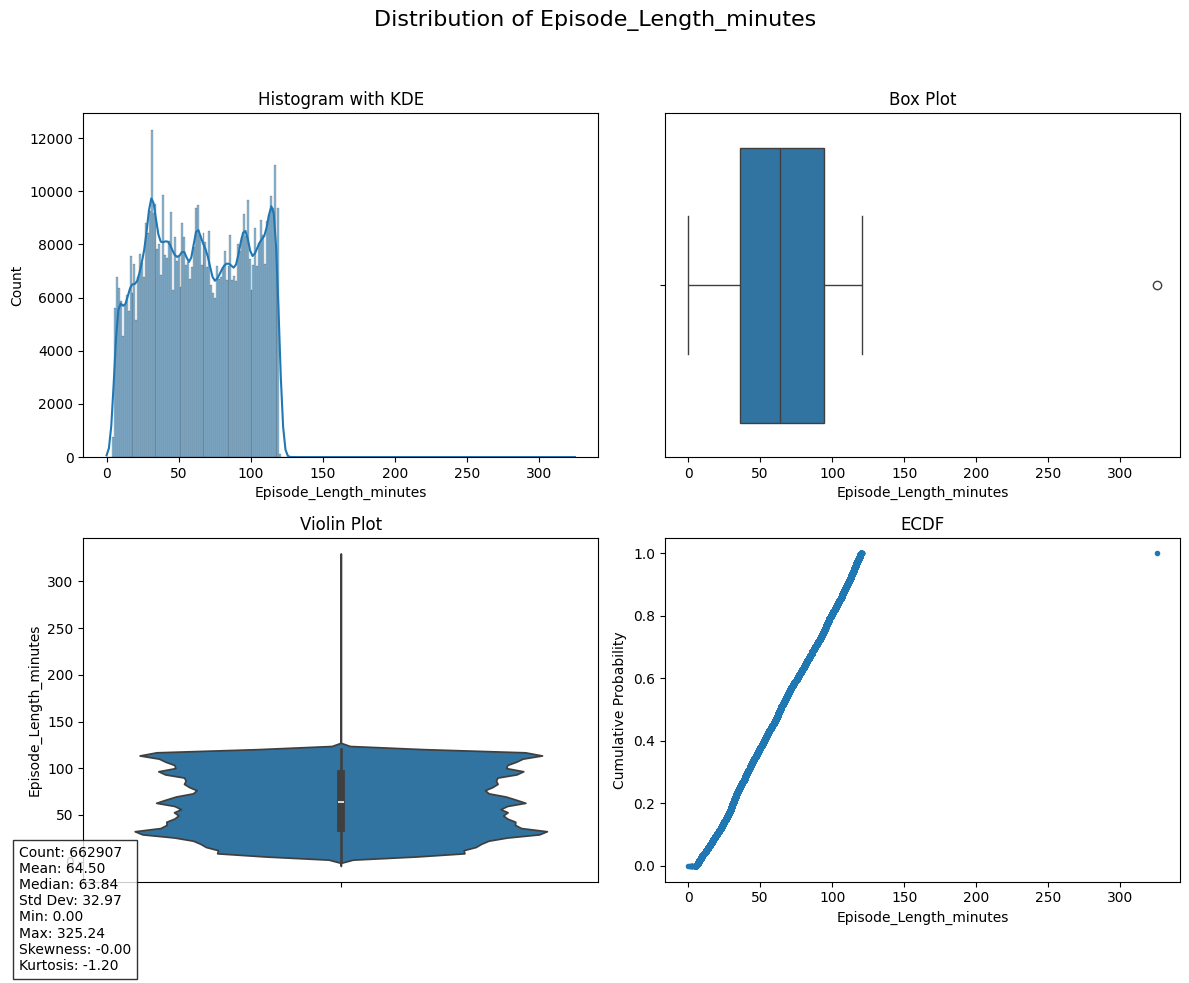


Basic Statistics for Episode_Length_minutes:
Count: 662907
Mean: 64.50
Median: 63.84
Std Dev: 32.97
Min: 0.00
Max: 325.24
Skewness: -0.00
Kurtosis: -1.20
Potential outliers: 1 (0.00%)


In [26]:
# examine the distribution of Episode_Length_minutes to determine how to fill the nulls
visualize_distribution(train_encoded_df, 'Episode_Length_minutes')

In [27]:
# based on the data distribution the filling with mean strategy seems best for 'Episode_Length_minutes'
train_encoded_df_clean['Episode_Length_minutes'] = train_encoded_df_clean['Episode_Length_minutes'].fillna(train_encoded_df_clean['Episode_Length_minutes'].mean(), inplace=False)

In [28]:
# examine null values again across columns
train_encoded_df_clean.isna().sum()

Episode_Length_minutes                                 0
Host_Popularity_percentage                             0
Guest_Popularity_percentage                       123858
Number_of_Ads                                          0
Listening_Time_minutes                                 0
Podcast_Name_clustered_Sports Weekly_cluster_1         0
Podcast_Name_clustered_Tech Talks_cluster_0            0
Podcast_Name_clustered_Tech Trends_cluster_2           0
Episode_Title_binned_early                             0
Episode_Title_binned_late                              0
Episode_Title_binned_mid                               0
Genre_Business                                         0
Genre_Comedy                                           0
Genre_Education                                        0
Genre_Health                                           0
Genre_Lifestyle                                        0
Genre_Music                                            0
Genre_News                     

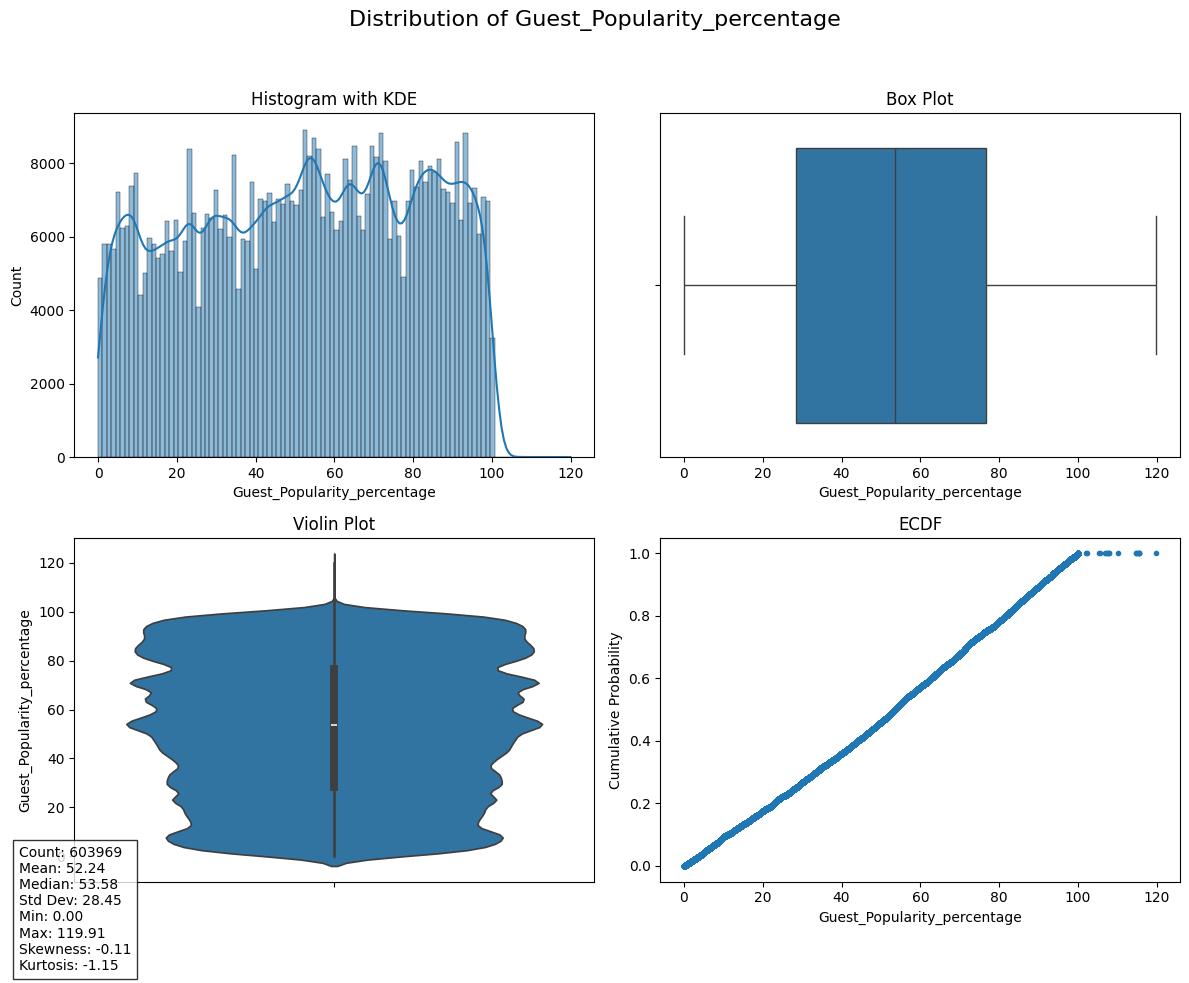


Basic Statistics for Guest_Popularity_percentage:
Count: 603969
Mean: 52.24
Median: 53.58
Std Dev: 28.45
Min: 0.00
Max: 119.91
Skewness: -0.11
Kurtosis: -1.15
Potential outliers: 0 (0.00%)


In [29]:
# examine the distribution of Guest_Popularity_percentage to determine how to fill the nulls
visualize_distribution(train_encoded_df_clean, 'Guest_Popularity_percentage')

In [30]:
# based on the data distribution the filling with mean strategy seems best for 'Guest_Popularity_percentage'
train_encoded_df_clean['Guest_Popularity_percentage'] = train_encoded_df_clean['Guest_Popularity_percentage'].fillna(train_encoded_df_clean['Guest_Popularity_percentage'].mean(), inplace=False)

In [31]:
# examine null values again across columns
train_encoded_df_clean.isna().sum()

Episode_Length_minutes                            0
Host_Popularity_percentage                        0
Guest_Popularity_percentage                       0
Number_of_Ads                                     0
Listening_Time_minutes                            0
Podcast_Name_clustered_Sports Weekly_cluster_1    0
Podcast_Name_clustered_Tech Talks_cluster_0       0
Podcast_Name_clustered_Tech Trends_cluster_2      0
Episode_Title_binned_early                        0
Episode_Title_binned_late                         0
Episode_Title_binned_mid                          0
Genre_Business                                    0
Genre_Comedy                                      0
Genre_Education                                   0
Genre_Health                                      0
Genre_Lifestyle                                   0
Genre_Music                                       0
Genre_News                                        0
Genre_Sports                                      0
Genre_Techno

### Train / Validation Split 

In [32]:
# make sure all data types are numerical (or boolean)
train_encoded_df_clean.dtypes

Episode_Length_minutes                            float64
Host_Popularity_percentage                        float64
Guest_Popularity_percentage                       float64
Number_of_Ads                                     float64
Listening_Time_minutes                            float64
Podcast_Name_clustered_Sports Weekly_cluster_1       bool
Podcast_Name_clustered_Tech Talks_cluster_0          bool
Podcast_Name_clustered_Tech Trends_cluster_2         bool
Episode_Title_binned_early                           bool
Episode_Title_binned_late                            bool
Episode_Title_binned_mid                             bool
Genre_Business                                       bool
Genre_Comedy                                         bool
Genre_Education                                      bool
Genre_Health                                         bool
Genre_Lifestyle                                      bool
Genre_Music                                          bool
Genre_News    

In [33]:
# create X (features) and y (target)
X = train_encoded_df_clean[[col for col in list(train_encoded_df_clean.columns) if col != 'Listening_Time_minutes']]
y = train_encoded_df_clean['Listening_Time_minutes']

In [34]:
# Split into training and testing sets (keeping random_state constant)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

### Model Training

In [35]:
# start with a very simple model pipeline to get a baseline

# create and train the model
simple_linear_model = LinearRegression()

# train the model
simple_linear_model.fit(X_train, y_train)

# make predictions
y_pred = simple_linear_model.predict(X_test)

# evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)

print(f"Root Mean Squared Error for Simple Linear Model: {rmse:.4f}")

Root Mean Squared Error for Simple Linear Model: 12.9580
